# Project 1 in Machine Learning, Kernel-trick

**Author:** Antoine Cornaz, Zayneb Melloui, Anas Himmi
**Date:** 1.11.2024

## 1. Introduction

### 1.1 Problem Statement
This machine learning project consists of two main phases. The dataset used contains medical records of patients, both healthy and those diagnosed with cardiovascular disease (CVD). The first phase focuses on implementing the functions covered in class and exercise sessions. The second phase aims to optimize the model for the best possible prediction, simulating a real-world scenario.

### 1.2 Objective

The objective of this project is to develop a machine learning model capable of predicting the presence of cardiovascular disease (CVD) in patients based on their medical information. The performance of the model will be evaluated using the following metrics:
- **Accuracy**: To measure the overall correctness of the model's predictions.
- **F1-Score**: To assess the balance between precision and recall, particularly for the CVD class.
- **False Positive Rate (FPR)**: To evaluate the proportion of healthy patients incorrectly classified as having CVD.
- **True Positive Rate (TPR)**: To measure the proportion of patients with CVD correctly identified by the model.

The goal is to optimize the model to achieve the best possible performance on these metrics, simulating real-world predictive scenarios.

### 1.3 Dataset Description
The dataset consists of records from 328,135 patients, each described by 321 dimensions containing various medical information. While none of the patients have all 321 medical fields fully populated, 92 key medical attributes are consistently available for every patient. The data originates from the **Behavioral Risk Factor Surveillance System (BRFSS)**, a health-related telephone survey system that gathers state-level data on U.S. residents. The BRFSS focuses on health-related risk behaviors, chronic health conditions, and the usage of preventive health services. This dataset provides a rich source of information for analyzing cardiovascular disease (CVD) and related health factors.

## 2. Data Loading and Exploration

## 2.1 Import and Initialisation

In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from implementation import *
from helpers import *
from visualisation import *

import sys


%load_ext autoreload
%autoreload 2

In [3]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data", sub_sample=True)

## 2.2 Exploration and Visualisation

In [4]:
#D = 321
#N = 6563. subset of the dataset
N, D = x_train.shape
N, D

(6563, 321)

In [5]:
# 0 patient with every dimension filled.
# 89 features are completed by all participant
nan_array = np.isnan(x_train)
print(np.sort((nan_array.sum(axis=0) ), axis=0)[0])
print(np.sort((nan_array.sum(axis=1) ), axis=0)[0])

0
89


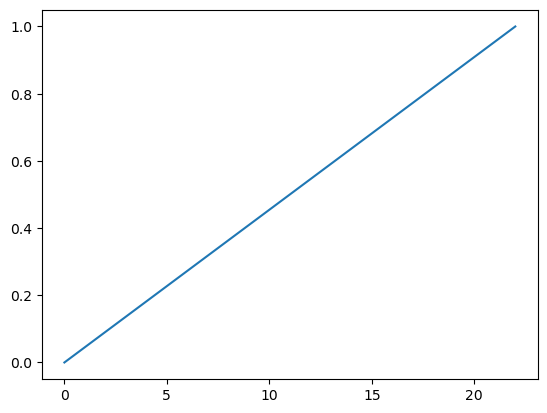

In [6]:
# Correlation between individual feature and expectation
#TODO move from anas_jpn to file and plot
correlation = correlation_f(x_train, y_train)
plt.plot(correlation)

# 3. Data Preprocessing

In [ ]:
# Remove features with correlation smaller than 0.1
#TODO
x_train, y_train = remove_uncorrelated_feature(x_train, y_train)

In [8]:
# discard the features that have a nan ratio greater than 0.05 from most_correlated_features
#TODO
x_train, y_train = remove_unsuffisant_data_feature(x_train, y_train)

## 3.1 Handling Missing Values

# 4. Train/Test Split

## 4.1 Splitting the Dataset

# 5. Model Selection and Training

## 5.1 Model Selection

## 5.2 Training the Models

# 6. Model Evaluation

# 7. Model Optimization

## 7.1 Hyperparameter Tuning